<a href="https://colab.research.google.com/github/moushumipriya/Used-Car-Price-Prediction-/blob/main/Car_Price_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor # Import RandomForestRegressor

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

file_path = "/content/drive/MyDrive/car_listings.csv"
df = pd.read_csv(file_path)

print("Original Columns:", df.columns.tolist())
print("Original Shape:", df.shape)


Original Columns: ['ID', 'AutoTraderID', 'AutoTraderDealerID', 'Source', 'SourceID', 'VIN', 'StockNo', 'ManufactureYear', 'ColourBody', 'Odometer', 'Rego', 'RegoExpiry', 'Make', 'Model', 'Variant', 'Series', 'Status', 'SoldDate', 'URL', 'Lat', 'Lon', 'CreatedAt', 'UpdatedAt', 'DeletedAt', 'DealerName', 'MinPrice']
Original Shape: (125552, 26)


In [3]:
drop_cols = [
    "ID", "AutoTraderID", "AutoTraderDealerID", "Source", "SourceID",
    "VIN", "StockNo", "Rego", "RegoExpiry", "Status", "SoldDate",
    "URL", "Lat", "Lon", "CreatedAt", "UpdatedAt", "DeletedAt", "DealerName"
]

df = df.drop(columns=drop_cols)
print("Remaining Columns:", df.columns.tolist())
print("New Shape:", df.shape)


Remaining Columns: ['ManufactureYear', 'ColourBody', 'Odometer', 'Make', 'Model', 'Variant', 'Series', 'MinPrice']
New Shape: (125552, 8)


In [4]:
# Missing value check
print("Missing values:\n", df.isnull().sum())

# Odometer, ManufactureYear, MinPrice → numeric fill
df["Odometer"] = df["Odometer"].fillna(df["Odometer"].median())
df["ManufactureYear"] = df["ManufactureYear"].fillna(df["ManufactureYear"].median())
df["MinPrice"] = df["MinPrice"].fillna(df["MinPrice"].median())

# Categorical columns fill
for col in ["ColourBody", "Make", "Model", "Variant", "Series"]:
    df[col] = df[col].fillna("Unknown")


Missing values:
 ManufactureYear        0
ColourBody          9908
Odometer               0
Make                   0
Model                  5
Variant             6285
Series             16458
MinPrice               0
dtype: int64


In [5]:
le = LabelEncoder()
for col in ["ColourBody", "Make", "Model", "Variant", "Series"]:
    df[col] = le.fit_transform(df[col])


In [6]:
X = df.drop(columns=["MinPrice"])   # Features
y = df["MinPrice"]                 # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)


Train Shape: (100441, 7)
Test Shape: (25111, 7)


In [20]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [8]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print("RMSE:", rmse)
print("R² Score:", r2)


Model Performance:
RMSE: 27722.794921378107
R² Score: 0.14592610459472088


In [9]:
example = X_test.iloc[0:1]
predicted_price = model.predict(example)

print("Example Car Features:\n", example)
print("Predicted Price:", predicted_price[0])
print("Actual Price:", y_test.iloc[0])


Example Car Features:
        ManufactureYear  ColourBody  Odometer  Make  Model  Variant  Series
17749             2023         170     10489    45    721     5331    2566
Predicted Price: 44915.37863359577
Actual Price: 47950


In [21]:
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor # Ensure RandomForestRegressor is imported


joblib.dump(model, "car_price_model.pkl")


encoders = {}
# Re-fit LabelEncoders on the original string data before saving
original_df = pd.read_csv(file_path)
drop_cols = [
    "ID", "AutoTraderID", "AutoTraderDealerID", "Source", "SourceID",
    "VIN", "StockNo", "Rego", "RegoExpiry", "Status", "SoldDate",
    "URL", "Lat", "Lon", "CreatedAt", "UpdatedAt", "DeletedAt", "DealerName"
]

original_df = original_df.drop(columns=drop_cols)

for col in ["ColourBody", "Make", "Model", "Variant", "Series"]:
    le = LabelEncoder()
    # Handle missing values before fitting the encoder
    original_df[col] = original_df[col].fillna("Unknown")
    le.fit(original_df[col])
    encoders[col] = le

joblib.dump(encoders, "encoders.pkl")

['encoders.pkl']

In [23]:
import pandas as pd
import joblib

# Load model and encoders
model = joblib.load("car_price_model.pkl")
encoders = joblib.load("encoders.pkl")

def predict_car_price(car_features):
    """
    car_features = dict, e.g.,
    {
        "ManufactureYear": 2019,
        "Odometer": 25000,
        "Make": "Toyota",
        "Model": "Corolla",
        "Variant": "XLE",
        "ColourBody": "White",
        "Series": "Series1"
    }
    """
    # Encode categorical columns
    for col in ["ColourBody", "Make", "Model", "Variant", "Series"]:
        # Handle unseen labels by mapping them to 'Unknown'
        if car_features[col] not in encoders[col].classes_:
            car_features[col] = 'Unknown'
        car_features[col] = encoders[col].transform([car_features[col]])[0]

    # Ensure the order of columns matches the training data
    feature_order = ['ManufactureYear', 'ColourBody', 'Odometer', 'Make', 'Model', 'Variant', 'Series']
    X = pd.DataFrame([car_features], columns=feature_order)
    predicted_price = model.predict(X)[0]

    return predicted_price

In [24]:
car = {
    "ManufactureYear": 2019,
    "Odometer": 25000,
    "Make": "Toyota",
    "Model": "Corolla",
    "Variant": "XLE",
    "ColourBody": "White",
    "Series": "Series1"
}

price = predict_car_price(car)
print(f"Predicted Car Price: ${price:.2f}")


Predicted Car Price: $36778.50


Linear Regression Performance:
RMSE: 27722.79, MAE: 15755.02, R²: 0.15

Random Forest Regression Performance:
RMSE: 62000.57, MAE: 6572.01, R²: -3.27



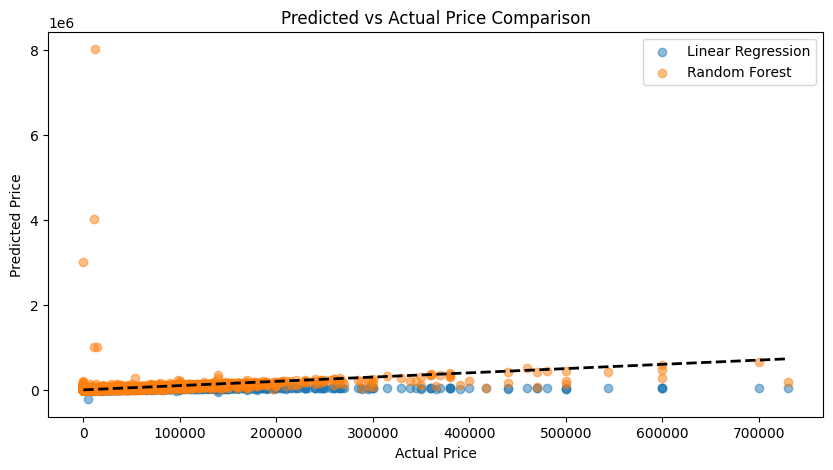

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression # Import LinearRegression
from sklearn.ensemble import RandomForestRegressor # Ensure RandomForestRegressor is imported


# Train Linear Regression model (if not already trained)
# Assuming X_train, X_test, y_train, y_test are already defined
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)


# Assuming rf_model is the trained RandomForestRegressor model from previous steps
# If not, you might need to load it or ensure the variable name matches
rf_model = model # Assuming 'model' is your trained RandomForestRegressor

# Predictions
y_pred_lr = linear_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Metrics
def print_metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Performance:")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}\n")

print_metrics(y_test, y_pred_lr, "Linear Regression")
print_metrics(y_test, y_pred_rf, "Random Forest Regression")

# Plot predictions vs actual
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred_lr, alpha=0.5, label="Linear Regression")
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Random Forest")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Price Comparison")
plt.legend()
plt.show()